<a href="https://colab.research.google.com/github/Anonymous390/NNFS-MNIST-with-Convolution/blob/main/MNIST_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install nnfs

Imports

In [17]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data
import os
from PIL import Image
import cv2

Load Training and Testing Data

In [18]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# X_train = X_train.reshape(X_train.shape[0], -1)
# Reshape to include channel dimension (for Conv2D)
X_train = X_train.reshape(-1, 28, 28, 1)  # Shape: (60000, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)     # Shape: (10000, 28, 28, 1)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


Neural Network Classes

In [19]:
class Layer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    def __init__(self):
        pass
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def __init__(self):
        pass
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        prob_dist = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = prob_dist

class Loss:
    def __init__(self):
        pass
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_categorical_cross_entropy(Loss):
    def __init__(self):
        pass
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred*y_true, axis=1)

        neg_log = -np.log(correct_confidences)
        return neg_log

class Activation_Softmax_Loss(Loss):
    def __init__(self):
        super().__init__()
        self.activation = Activation_Softmax()
        self.loss = Loss_categorical_cross_entropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples


Conv Neural Network

In [20]:
class Conv2D:
    def __init__(self, filters, kernel_size=3, stride=1, padding=0, in_channels=1):
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Xavier/He initialization
        fan_in = kernel_size * kernel_size * in_channels
        self.weights = np.random.randn(
            kernel_size, kernel_size, in_channels, filters
        ) * np.sqrt(2.0 / fan_in)

        self.biases = np.zeros(filters)
        self.inputs = None
        self.padded_inputs = None

    def im2col(self, inputs):
        batch_size, in_h, in_w, in_c = inputs.shape

        if self.padding > 0:
            inputs = np.pad(inputs, ((0,0), (self.padding,self.padding),
                           (self.padding,self.padding), (0,0)), mode='constant')
            in_h += 2 * self.padding
            in_w += 2 * self.padding

        self.padded_inputs = inputs

        # Calculate output dimensions
        out_h = (in_h - self.kernel_size) // self.stride + 1
        out_w = (in_w - self.kernel_size) // self.stride + 1

        # Create column matrix
        col = np.zeros((batch_size * out_h * out_w, self.kernel_size * self.kernel_size * in_c))

        for y in range(self.kernel_size):
            y_max = y + self.stride * out_h
            for x in range(self.kernel_size):
                x_max = x + self.stride * out_w
                for c in range(in_c):
                    col[:, (y * self.kernel_size + x) * in_c + c] = \
                        inputs[:, y:y_max:self.stride, x:x_max:self.stride, c].ravel()

        return col, out_h, out_w

    def forward(self, inputs):
        self.inputs = inputs
        batch_size, in_h, in_w, in_c = inputs.shape

        # Update weights shape based on actual input channels
        if self.weights.shape[2] != in_c:
            fan_in = self.kernel_size * self.kernel_size * in_c
            self.weights = np.random.randn(
                self.kernel_size, self.kernel_size, in_c, self.filters
            ) * np.sqrt(2.0 / fan_in)

        # Convert to column format
        col, out_h, out_w = self.im2col(inputs)

        W_col = self.weights.reshape(-1, self.filters)

        output = np.dot(col, W_col) + self.biases

        self.output = output.reshape(batch_size, out_h, out_w, self.filters)

        return self.output

    def col2im(self, col, input_shape):
        batch_size, in_h, in_w, in_c = input_shape

        # Add padding to input shape
        if self.padding > 0:
            in_h += 2 * self.padding
            in_w += 2 * self.padding

        # Calculate output dimensions
        out_h = (in_h - self.kernel_size) // self.stride + 1
        out_w = (in_w - self.kernel_size) // self.stride + 1

        # Initialize output
        img = np.zeros((batch_size, in_h, in_w, in_c))

        for y in range(self.kernel_size):
            y_max = y + self.stride * out_h
            for x in range(self.kernel_size):
                x_max = x + self.stride * out_w
                for c in range(in_c):
                    img[:, y:y_max:self.stride, x:x_max:self.stride, c] += \
                        col[:, (y * self.kernel_size + x) * in_c + c].reshape(batch_size, out_h, out_w)

        return img

    def backward(self, dvalues):
        batch_size, out_h, out_w, out_c = dvalues.shape

        # Flatten dvalues
        dvalues_flat = dvalues.reshape(-1, self.filters)

        # Get column representation of inputs
        col, _, _ = self.im2col(self.inputs)

        # Compute gradients
        self.dweights = np.dot(col.T, dvalues_flat).reshape(self.weights.shape)
        self.dbiases = np.sum(dvalues_flat, axis=0)

        # Compute input gradients
        W_col = self.weights.reshape(-1, self.filters)
        dcol = np.dot(dvalues_flat, W_col.T)

        # Convert back to image format
        dinputs_padded = self.col2im(dcol, self.inputs.shape)

        # Remove padding if it was added
        if self.padding > 0:
            self.dinputs = dinputs_padded[:, self.padding:-self.padding,
                                        self.padding:-self.padding, :]
        else:
            self.dinputs = dinputs_padded

        return self.dinputs

MaxPooling Layer

In [21]:
class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride
        self.inputs = None
        self.mask = None
        self.output = None

    def forward(self, inputs):
        self.inputs = inputs
        batch_size, in_h, in_w, in_c = inputs.shape

        out_h = (in_h - self.pool_size) // self.stride + 1
        out_w = (in_w - self.pool_size) // self.stride + 1

        # Reshape input for pooling
        reshaped = inputs[:, :out_h*self.stride, :out_w*self.stride, :].copy()
        reshaped = reshaped.reshape(batch_size, out_h, self.stride, out_w, self.stride, in_c)
        reshaped = reshaped.transpose(0, 1, 3, 5, 2, 4)
        reshaped = reshaped.reshape(batch_size, out_h, out_w, in_c, -1)

        # Find max and create mask
        self.output = np.max(reshaped, axis=-1)
        max_indices = np.argmax(reshaped, axis=-1)

        # Create mask for backward pass
        self.mask = np.zeros_like(reshaped, dtype=bool)
        batch_idx, h_idx, w_idx, c_idx = np.indices(max_indices.shape)
        self.mask[batch_idx, h_idx, w_idx, c_idx, max_indices] = True

        return self.output

    def backward(self, dvalues):
        batch_size, out_h, out_w, in_c = dvalues.shape

        # Expand gradients using mask
        expanded_grad = np.zeros_like(self.mask, dtype=np.float32)
        expanded_grad[self.mask] = dvalues.ravel()

        # Reshape back to input shape
        expanded_grad = expanded_grad.reshape(batch_size, out_h, out_w, in_c, self.stride, self.stride)
        expanded_grad = expanded_grad.transpose(0, 1, 4, 2, 5, 3)
        self.dinputs = expanded_grad.reshape(batch_size, out_h*self.stride, out_w*self.stride, in_c)

        # Pad if necessary to match input shape
        if self.dinputs.shape != self.inputs.shape:
            pad_h = self.inputs.shape[1] - self.dinputs.shape[1]
            pad_w = self.inputs.shape[2] - self.dinputs.shape[2]
            self.dinputs = np.pad(self.dinputs, ((0,0), (0,pad_h), (0,pad_w), (0,0)))

        return self.dinputs

Optimisers

In [22]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum:

            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = self.momentum * layer.weight_momentums - self.learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.learning_rate * layer.dweights
            bias_updates = -self.learning_rate * layer.dbiases


        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

Creating My Model

In [24]:
conv1 = Conv2D(filters=32, kernel_size=3, padding=1)
activation1 = Activation_ReLU()

pool1 = MaxPool2D(pool_size=2, stride=2)

flatten = lambda x: x.reshape(x.shape[0], -1)

layer1 = Layer(14*14*32, 128)
activation2 = Activation_ReLU()

layer2 = Layer(128, 10)
softmax2 = Activation_Softmax()

loss_func = Activation_Softmax_Loss()

optimizer = Optimizer_SGD(learning_rate=.1, decay=1e-3, momentum=0.9)

Forward Pass

In [25]:
def forward_pass(X_batch, y_true):
    conv1.forward(X_batch)
    activation1.forward(conv1.output)
    pool1.forward(activation1.output)

    flatten_output = pool1.output.reshape(X_batch.shape[0], -1)
    layer1.forward(flatten_output)
    activation2.forward(layer1.output)
    layer2.forward(activation2.output)
    loss = loss_func.forward(layer2.output, y_true)

    return loss

Backward Pass

In [26]:
def backward_pass(dvalues, y_batch):
    loss_func.backward(dvalues, y_batch)
    layer2.backward(loss_func.dinputs)
    activation2.backward(layer2.dinputs)
    layer1.backward(activation2.dinputs)

    pool_grad = layer1.dinputs.reshape(
        pool1.output.shape[0],  # batch
        pool1.output.shape[1],  # height
        pool1.output.shape[2],  # width
        pool1.output.shape[3]   # channels
    )
    pool1.backward(pool_grad)
    activation1.backward(pool1.dinputs)
    conv1.backward(activation1.dinputs)

Training My Model

In [27]:
accuracy = 0
loss = 1

batch_size = 64
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train[permutation]

    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = X_train.shape[0] // batch_size

    for batch_idx in range(num_batches):
        # Get batch
        start = batch_idx * batch_size
        end = start + batch_size
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        # Forward pass
        loss = forward_pass(X_batch, y_batch)


        # Calculate accuracy
        predictions = np.argmax(layer2.output, axis=1)
        true_labels = np.argmax(y_batch, axis=1) if len(y_batch.shape) == 2 else y_batch
        batch_accuracy = np.mean(predictions == true_labels)

        # Backward pass
        backward_pass(loss_func.output, y_batch)
        # Update weights
        optimizer.pre_update_params()
        optimizer.update_params(layer2)
        optimizer.update_params(layer1)
        # Update weights for the Conv2D layer
        optimizer.update_params(conv1)
        optimizer.post_update_params()

        epoch_loss += loss
        epoch_accuracy += batch_accuracy

    avg_loss = epoch_loss / num_batches
    avg_accuracy = epoch_accuracy / num_batches
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Accuracy = {avg_accuracy:.4f}")

Epoch 1: Loss = 0.1584, Accuracy = 0.9499
Epoch 2: Loss = 0.0506, Accuracy = 0.9840
Epoch 3: Loss = 0.0279, Accuracy = 0.9909
Epoch 4: Loss = 0.0181, Accuracy = 0.9941
Epoch 5: Loss = 0.0109, Accuracy = 0.9964


Testing My Model

(10000, 28, 28, 1)
7


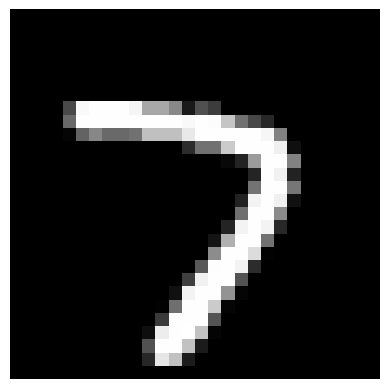

Test Accuracy: 0.9863


In [28]:
X_test = X_test.reshape(-1, 28, 28, 1)
print(X_test.shape)
loss = forward_pass(X_test, y_test)

test_predictions = np.argmax(loss_func.output, axis=1)
test_true = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_predictions == test_true)
print(test_predictions[17])
plt.imshow(X_test[17], cmap="gray")
plt.axis('off')
plt.show()
print(f"Test Accuracy: {test_accuracy:.4f}")

Incorrect guesses

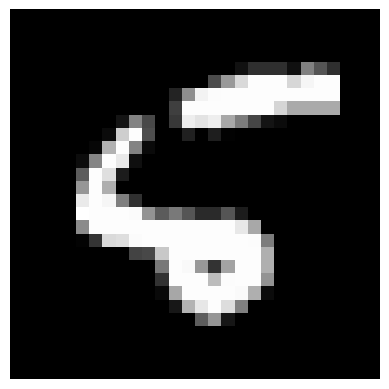

Predicted: 6, True: 5


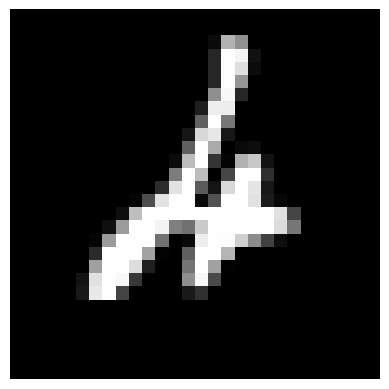

Predicted: 2, True: 4


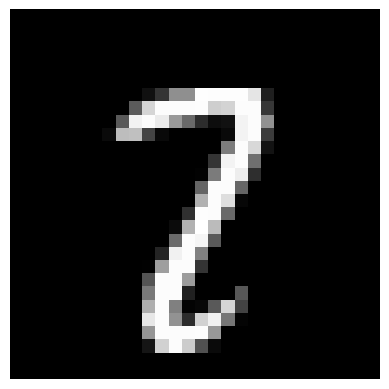

Predicted: 7, True: 2


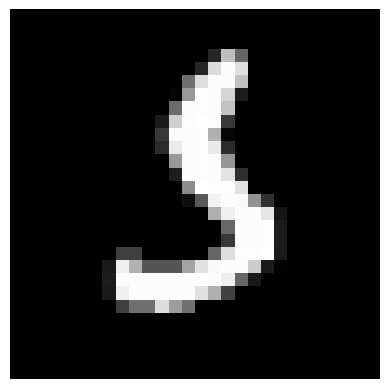

Predicted: 3, True: 5


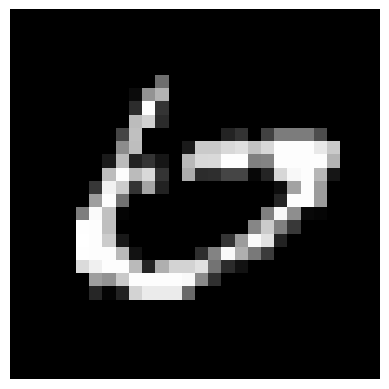

Predicted: 0, True: 6


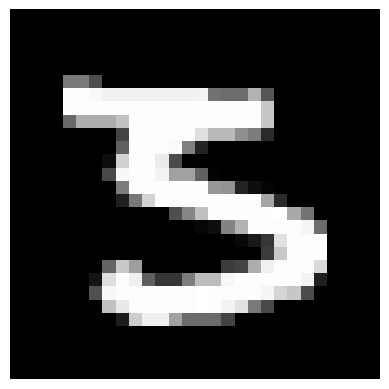

Predicted: 5, True: 3


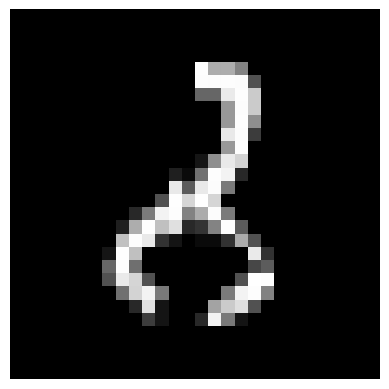

Predicted: 2, True: 8


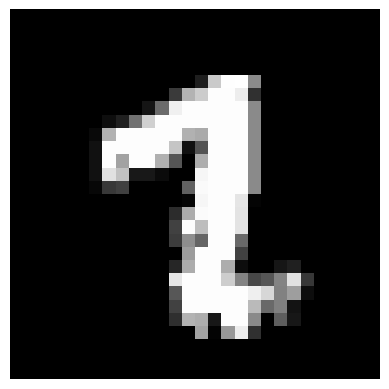

Predicted: 7, True: 2


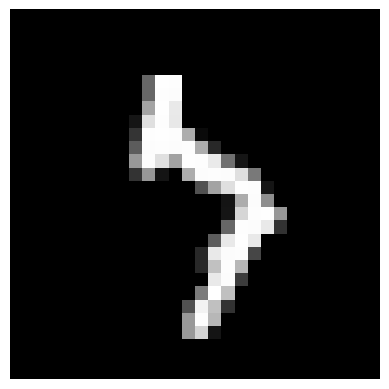

Predicted: 5, True: 7


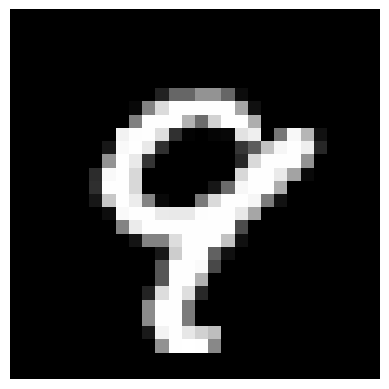

Predicted: 8, True: 9


In [29]:
incorrect_guesses = np.where(test_predictions != test_true)[0]
first_10_incorrect = incorrect_guesses[:10]

for idx in first_10_incorrect:
    plt.imshow(X_test[idx], cmap="gray")
    plt.axis('off')
    plt.show()

    print(f"Predicted: {test_predictions[idx]}, True: {test_true[idx]}")

Custom Test

(28, 28)


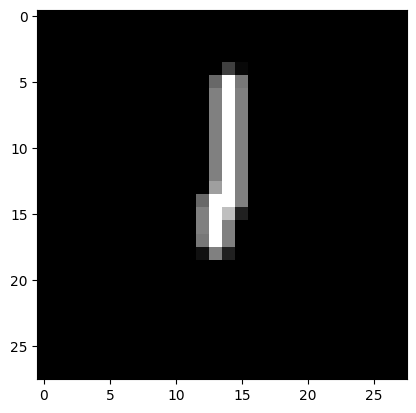

In [30]:
file = "pred1.png"
test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (28, 28), interpolation=cv2.INTER_LINEAR)
test_image = cv2.bitwise_not(test_image)
test_image = test_image / 255.0
print(test_image.shape)

plt.imshow(test_image, cmap="gray")
plt.show()

img_array = np.array(test_image)

(1, 28, 28, 1)
0: 0.000000 %
1: 99.999879 %
2: 0.000000 %
3: 0.000000 %
4: 0.000038 %
5: 0.000000 %
6: 0.000000 %
7: 0.000043 %
8: 0.000000 %
9: 0.000039 %
Predicted digit: 1


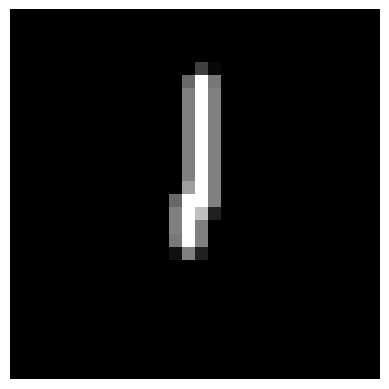

In [36]:
img_flattened = img_array.reshape(1,28,28,1)

print(img_flattened.shape)

conv1.forward(img_flattened)
activation1.forward(conv1.output)
pool1.forward(activation1.output)

flatten_output = pool1.output.reshape(img_flattened.shape[0], -1)
layer1.forward(flatten_output)
activation2.forward(layer1.output)
layer2.forward(activation2.output)
softmax2.forward(layer2.output)

predicted_class = np.argmax(softmax2.output, axis=1)
for i, p in enumerate(softmax2.output[0]):
    print(f"{i}: {(p*100):.6f} %")
print("Predicted digit:", predicted_class[0])
plt.imshow(img_array, cmap="gray")
plt.axis('off')
plt.show()

Saving the Model with weights and bias

In [33]:
class ModelSaver:
    @staticmethod
    def save_model(conv1, layer1, layer2, optimizer=None, path='model.npz'):
        save_dict = {
            'conv1_weights': conv1.weights,
            'conv1_biases': conv1.biases,
            'layer1_weights': layer1.weights,
            'layer1_biases': layer1.biases,
            'layer2_weights': layer2.weights,
            'layer2_biases': layer2.biases
        }

        # Save optimizer state if provided
        if optimizer is not None:
            if hasattr(optimizer, 'weight_momentums'):
                save_dict['opt_weight_momentums_layer1'] = optimizer.weight_momentums
                save_dict['opt_bias_momentums_layer1'] = optimizer.bias_momentums
            if hasattr(optimizer, 'iterations'):
                save_dict['opt_iterations'] = optimizer.iterations

        np.savez(path, **save_dict)
        print(f"✅ Model saved to '{path}'")

    @staticmethod
    def load_model(conv1, layer1, layer2, optimizer=None, path='model.npz'):
        data = np.load(path)

        conv1.weights = data['conv1_weights']
        conv1.biases = data['conv1_biases']
        layer1.weights = data['layer1_weights']
        layer1.biases = data['layer1_biases']
        layer2.weights = data['layer2_weights']
        layer2.biases = data['layer2_biases']

        # Load optimizer state if available
        if optimizer is not None:
            if 'opt_weight_momentums_layer1' in data:
                optimizer.weight_momentums = data['opt_weight_momentums_layer1']
                optimizer.bias_momentums = data['opt_bias_momentums_layer1']
            if 'opt_iterations' in data:
                optimizer.iterations = int(data['opt_iterations'])

        print(f"✅ Model loaded from '{path}'")

In [34]:
saver = ModelSaver()
saver.save_model(conv1, layer1, layer2, optimizer)

✅ Model saved to 'model.npz'
